---
title: Improper Integrals
venue: Modules
---

## Numerical evaluation of improper integrals

The <b> QuadGK</b> package transforms an infinite interval into a finite one, then aplies the Gauss-Kronrod quadrature. It avoids evaluating the endpoints to prevent singularities: https://juliamath.github.io/QuadGK.jl/stable/quadgk-examples/#quadgk-examples

<b> Example: </b> Integrate the Gauss function $f(x)=e^{-x^2}$ over the real line $(-\infty,\infty)$

In [1]:
import QuadGK as qgk
f(x) = exp(-x^2);
result = qgk.quadgk(f, -Inf, Inf)[1]

1.7724538509055137

The exact value for the integral is $\int_{-\infty}^{\infty}f(x) \ dx =\sqrt{\pi}$

In [2]:
print("The numerical error for the improper integral is ", result - sqrt(pi))

The numerical error for the improper integral is -2.220446049250313e-15

You can also specify the accuracy of the numerical integral with 'rtol' that controls the relative convergence of the algorithm:

In [3]:
result2 = qgk.quadgk(f, -Inf, Inf, rtol=1e-2)[1]
print("The numerical error for the less accurate integral is ", result2 - sqrt(pi))

The numerical error for the less accurate integral is -0.00023725818610764726

<b> Example: </b> Integral containing singularity $\int_0^1 \frac{dx}{\sqrt{x}}= 2\left[\sqrt{x}\right]_0^1=2$

In [4]:
g(x) = 1 / sqrt(x)
result = qgk.quadgk(g, 0, 1, rtol=1e-15)[1]
print("The numerical error for the improper integral is ", result - 2)

The numerical error for the improper integral is -2.220446049250313e-16

You can also specify the singularity within the interval, for example in  $\int_{-\infty}^{\infty} \frac{\sin(x)}{x} dx=\pi$

In [5]:
h(x) = sin(x) / x
result = qgk.quadgk(h, -Inf, 0, Inf, rtol=1e-15)[1]
print("The numerical value for the improper integral is ", result, ", error is ", result - pi)

The numerical value for the improper integral is -2.2883912437919642, error is -5.429983897381757

# Solutions to ODE and PDE using Improper Integrals

A <b> mass-spring-damper </b> system with displacement $x$, mass $m$, damping constant $d$, and spring constant $k$, while subject to an external force $f$, is governed by the following initial value problem:

\begin{equation}
m\ddot{x}+b\dot{x}+kx=f, \ x(0)=x_0,\  \dot{x}(0)=v_0
\end{equation}



The above equation can be solved with the help of <b> Laplace transforms </b>. Let $X=\mathcal{L}x, F=\mathcal{L}f$ be the Laplace transforms of $x,f$. Note that $X(s),F(s)$ are functions of a complex variable $s=\rho+\sigma \cdot i$. Then for zero initial values $x_0=0,v_0=0$, the solution $x$ can be obtained via inverse Laplace transform as follows:

\begin{equation}
 x(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{(\rho+\sigma i)t}\cdot \frac{F(\rho+\sigma i)}{(\rho+ \sigma i)^2+(\rho+\sigma i)+1 } \ d\sigma  
\end{equation}

Where $\rho$ is a fixed constant such that all poles of the integrand lie to the left of $\rho$ on the complex plane, i.e. their imaginary parts are less than $\rho$.


<b>Example:</b> Let $m=b=k=1$. The input forcing is unit step $u(t)$ with Laplace transform $U(s)=\frac{1}{s}$  Choose $\rho=2$. Then the solution is given by

\begin{equation}
 x(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{2t}e^{\sigma i t}\cdot \frac{ d\sigma }{(2+\sigma i)[(2+ \sigma i)^2+(2+\sigma i)+1 ]}  
\end{equation}



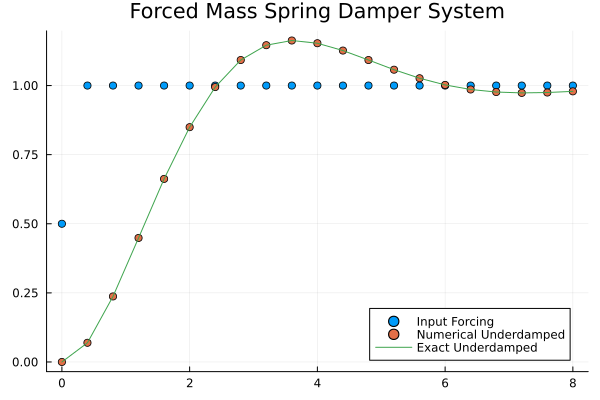

In [6]:
import Plots as Plt
import QuadGK as qgk

# Setup system parameters
unit_step(x) = 0.5 * (sign(x) + 1)
Laplace_ustep(s) = 1 / s

# Material constants for mass spring damper system
mass, damp, spring = ones(3)

# Laplace transforms of transfer function and input forcing function
transfer_function(s) = 1 / (mass * s .^ 2 + damp * s + spring)
input_f_lapl(s) = Laplace_ustep(s)

fun_lapl(s) = transfer_function.(s) .* input_f_lapl.(s)

# Parameters for exact solution
rho, omega = 1, sqrt(3 / 4)
zeta1, zeta2 = -0.5 * ones(2)
a, b, c = -1, -1 / sqrt(3), 1

# Start computations
t_start, t_end = 0, 8
time = range(t_start, t_end, step=0.4)
integrand(s) = exp.((rho + s * im) * time) .* fun_lapl(rho + s * im)
fun_solution = (2 * π)^(-1) * qgk.quadgk(integrand, -Inf, Inf)[1]

# Underdamped solution
exact_under = a * exp.(zeta1 * time) .* cos.(omega * time) .+ b * exp.(zeta2 * time) .* sin.(omega * time) .+ c

# Plot the results
Plt.scatter(time, unit_step, label="Input Forcing")
Plt.scatter!(time, real(fun_solution), label="Numerical Underdamped")
Plt.plot!(time, exact_under, label="Exact Underdamped")
Plt.title!("Forced Mass Spring Damper System")

More examples to play around with: http://lampx.tugraz.at/~hadley/physikm/apps/odeanalytic/dharmonic.en.php

# Solution of linear PDE: Heat Equation

The evolution of temperature distribution $T(x,t)$ on an infinitely long thin rod with thermal conductivity $\kappa$ and initial temperature $T(x,t=0)=T_0(x) $ without external input is governed by the    <b> heat equation:</b>

\begin{equation}
\frac{\partial T}{\partial t}=\kappa \frac{\partial^2 T}{\partial x^2}, \ t>0, \ x\in (-\infty,\infty), \ T(x,0)=T_0(x) 
\end{equation}



The above equation can be solved via convolution of the initial distribution $T_0$ with the <b> heat kernel </b> $\Phi(x,t)=\frac{1}{\sqrt{4\pi\kappa t}}\exp(-\frac{x^2}{4\kappa t}) $. The solution can be written as
\begin{equation}
 T(x,t) =  \int_{-\infty}^{\infty} \Phi(x-x',t)T_0(x')\  dx' =  \int_{-\infty}^{\infty} \frac{1}{\sqrt{4\pi\kappa t}}\cdot \exp\left(-\frac{(x-x')^2} {4\kappa t} \right) T_0(x')\  dx' \quad \quad (1)
\end{equation}

<b> Example: </b> Let the initial distribution be a Gaussian pulse centered around the origin $x=0$:

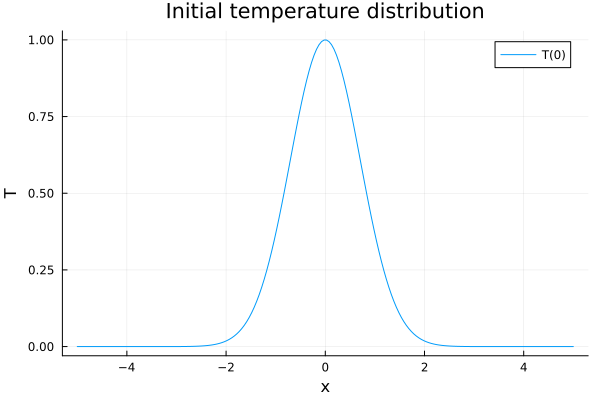

In [7]:
# Plot initial Gaussian distribution
startx, endx, stepx = -5, 5, 200
x = LinRange(startx, endx, stepx)
x0 = 0

# Define the inital distribution
initial_dist(x) = exp(-x.^2)

# Plot the results
Plt.plot(x, initial_dist.(x), label="T(0)")
Plt.title!("Initial temperature distribution")
Plt.xlabel!("x")
Plt.ylabel!("T")

Solution to the heat equation on the infinite line interval $[-\infty,\infty]$ with $\kappa=0.01$ and initial temperature distribution $T_0(x)=e^{-x^2}$:

\begin{equation}
 T(x,t) =  \int_{-\infty}^{\infty} \Phi(x-x',t)T_0(x')\  dx' =  \int_{-\infty}^{\infty} \frac{1}{\sqrt{4\pi \kappa t}}\cdot \exp\left(-\frac{(x-y)^2} {4 \kappa t} \right) e^{-y^2}\  dy 
 \end{equation}

[ Info: Saved animation to C:\Users\jjcun\Documents\me2060\modules\module_4\temp.gif


Plots.AnimatedGif("C:\\Users\\jjcun\\Documents\\me2060\\modules\\module_4\\temp.gif")
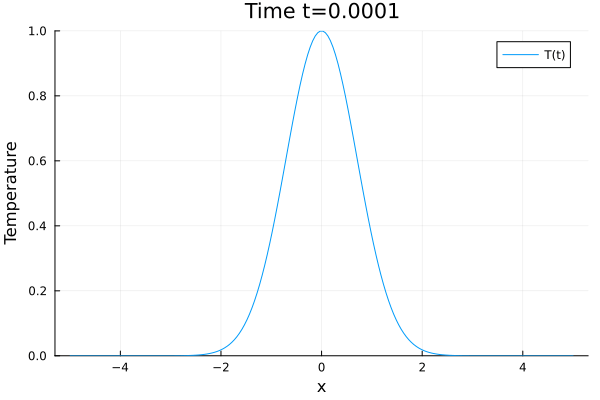

In [8]:
Nt = 101
t0 = 0.0001
t1 = 100
k = 0.01
duration = LinRange(t0, t1, Nt)

heat_kernel(x, t) = 1 ./ sqrt.(4 * pi * k * t) .* exp.(-x.^2 ./ (4 * k .* t))
anim = Plt.Animation()

for time in duration
    # Setup integrand for each time
    integrand(y) = heat_kernel.(x .- y, time) .* initial_dist(y)
    
    # Compute exact solution at each time with integral formula  
    temp = qgk.quadgk(integrand, -Inf, Inf)[1]

    # Plot the instance in time
    Plt.plot(x, temp, title="Time t="*string(time), label="T(t)")
    Plt.ylims!(0, 1)
    Plt.xlabel!("x")
    Plt.ylabel!("Temperature")
    Plt.frame(anim)
end
Plt.gif(anim, "temp.gif", fps=8)

<b>In-class exercise: </b>

Let the initial temperature distribution be:

a) rectangular pulse centered around the origin with height 1 and total width 0.5.

b) isosecles triangle centered around origin with height 1 and total base width 0.5


Solve the heat equation for these initial conditions over the same spatial domain as above with Eqn. (1), and create an animation to show the evolution of the temperature over the time 0<t<100. Which effect of the heat equation can you observe?

<b> Solution for (a): </b>

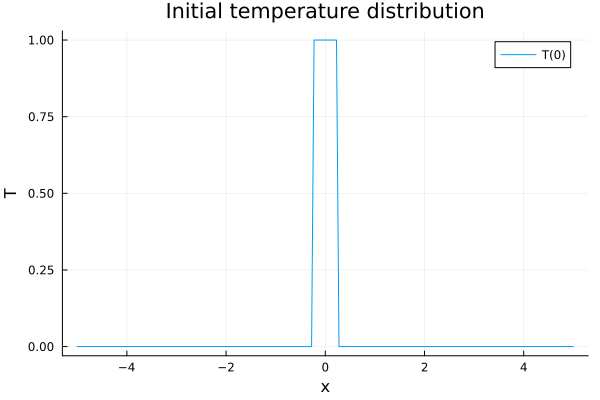

In [9]:
import Plots as Plt
import QuadGK as qgk

startx, endx, stepx = -5, 5, 200
x = LinRange(startx, endx, stepx)

# Define the initial distribution
initial_dist(x)= abs(x) <= 0.25

# Plot the results
Plt.plot(x, initial_dist.(x), label="T(0)")
Plt.title!("Initial temperature distribution")
Plt.xlabel!("x")
Plt.ylabel!("T")

[ Info: Saved animation to C:\Users\jjcun\Documents\me2060\modules\module_4\temp.gif


Plots.AnimatedGif("C:\\Users\\jjcun\\Documents\\me2060\\modules\\module_4\\temp.gif")
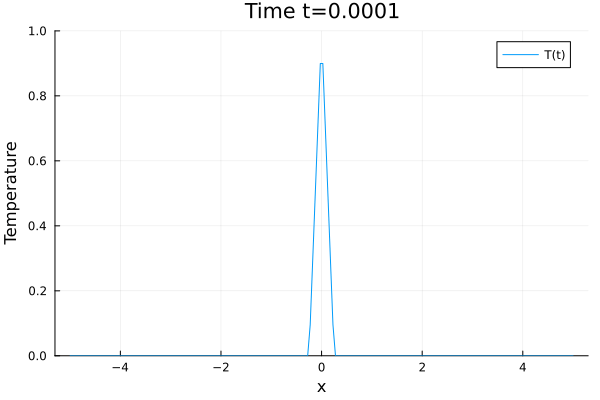

In [13]:
Nt = 101
t0 = 0.0001
t1 = 10
k = 0.01
duration = LinRange(t0, t1, Nt)

heat_kernel(x,t) =1 ./ sqrt.(4 * pi * k * t) .* exp.(-x.^2 ./ (4 * k .* t))
anim = Plt.Animation()

for time in duration
    # Setup integrand for each time
    integrand(y) = heat_kernel.(x .- y, time) .* initial_dist(y)
  
    # Compute exact solution at each time with integral formula  
    temp = qgk.quadgk(integrand, -Inf, Inf)[1]

    # Plot the instance in time
    Plt.plot(x, temp, label="T(t)")
    Plt.title!("Time t="*string(time))
    Plt.ylims!(0,1)
    Plt.xlabel!("x")
    Plt.ylabel!("Temperature")
    Plt.frame(anim)
end

Plt.gif(anim, "temp.gif", fps=8)

<b> Solution for (b): </b>

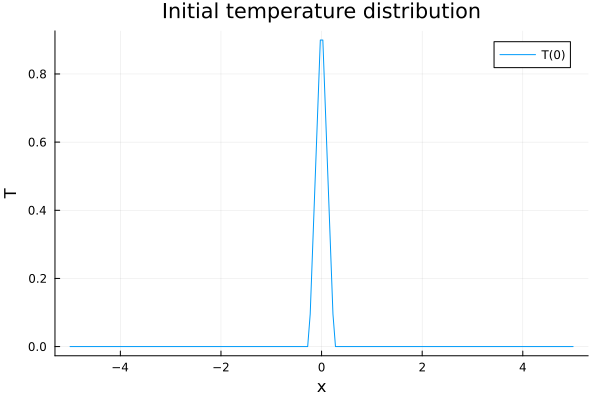

In [11]:
import Plots as Plt
import QuadGK as qgk

startx, endx, stepx = -5, 5, 200
x = LinRange(startx, endx, stepx)

# Define the initial distribution
b = 1
r1, r2, = -0.25, 0.25
m1, m2 = 4, -4

function initial_dist(x)
    if abs(x) > 0.25
        return 0
    elseif x >= -0.25 && x < 0
        return m1 * x + b
    elseif x >= 0 && x <= 0.25
        return m2 * x + b
    else
        return 0.0
    end
end

# Plot the results
Plt.plot(x, initial_dist.(x), label="T(0)")
Plt.title!("Initial temperature distribution")
Plt.xlabel!("x")
Plt.ylabel!("T")

[ Info: Saved animation to C:\Users\jjcun\Documents\me2060\modules\module_4\temp.gif


Plots.AnimatedGif("C:\\Users\\jjcun\\Documents\\me2060\\modules\\module_4\\temp.gif")
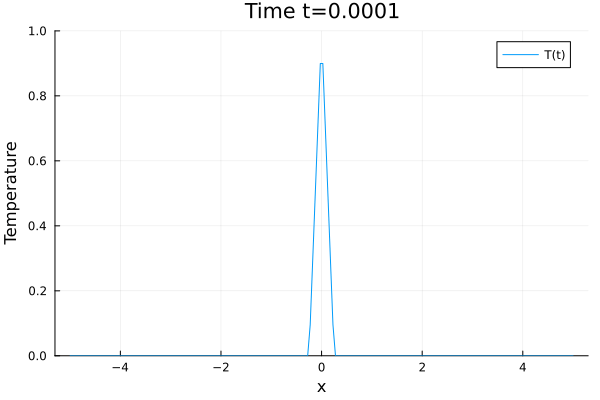

In [14]:
Nt = 101
t0 = 0.0001
t1 = 10
k = 0.01
duration = LinRange(t0, t1, Nt)

heat_kernel(x,t) =1 ./ sqrt.(4 * pi * k * t) .* exp.(-x.^2 ./ (4 * k .* t))
anim = Plt.Animation()

for time in duration
    # Setup integrand for each time
    integrand(y) = heat_kernel.(x .- y, time) .* initial_dist(y)
  
    # Compute exact solution at each time with integral formula  
    temp = qgk.quadgk(integrand, -Inf, Inf)[1]

    # Plot the instance in time
    Plt.plot(x, temp, label="T(t)")
    Plt.title!("Time t="*string(time))
    Plt.ylims!(0,1)
    Plt.xlabel!("x")
    Plt.ylabel!("Temperature")
    Plt.frame(anim)
end

Plt.gif(anim, "temp.gif", fps=8)